In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import calendar

In [128]:
#set display format of output from pandas
pd.set_option('display.float_format', lambda x: '%.6f' % x)
#extend chunksize for somes scatter plot
plt.rcParams['agg.path.chunksize'] = 10000

In [129]:
data_types = {
         'Id': np.dtype(int),
         'Store': np.dtype(int),
         'DayOfWeek': 'category',
         #'Date': np.dtype(str), # we will parse it later
         'Sales': np.dtype(int),
         'Customers': np.dtype(int),
         'Open': 'category',
         'Promo': 'category',
         'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(str)
         }

store_data_types = {
         'Store': np.dtype(int),
         'StoreType': np.dtype(str),
         'Assortment': np.dtype(str),
         'CompetitionDistance': np.dtype('float64'), # to prevent parsing null value
         'CompetitionOpenSinceMonth': np.dtype(str),
         'CompetitionOpenSinceYear': np.dtype(str),
         'Promo2': 'category',
         'Promo2SinceWeek': np.dtype(str),
         'Promo2SinceYear': np.dtype(str),
         'PromoInterval': np.dtype(str)
        }

train = pd.read_csv('input/train.csv', parse_dates=[2], dtype=data_types)
test = pd.read_csv('input/test.csv', parse_dates=[3], dtype=data_types)
store = pd.read_csv('input/store.csv', dtype=store_data_types)

## Data preparing

In [130]:
# train data
# remove the row that shops are closed
train = train[train["Open"] != '0']

In [131]:
# Merge with store data
train = pd.merge(train, store, on='Store')

In [132]:
# Add is Competition
# This feature is to check that on the day of sales on each store will have the competition store openned or not.

SalesAndCompetition = train[['Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
train['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')


In [133]:
# Add is Promo2
# This feature is to check that on the day of sales on each store will adapt the promotion in that month or not.

SalesAndPromo2 = train[['Date','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']]
SalesAndPromo2 = SalesAndPromo2.fillna({'Promo2SinceYear': '9999', 'Promo2SinceWeek': '99', 'PromoInterval': 'None'})
train['isPromo2'] = np.where((SalesAndPromo2.Date.dt.year >= SalesAndPromo2['Promo2SinceYear'].astype(int)) &
                             (SalesAndPromo2.Date.dt.week >= SalesAndPromo2['Promo2SinceWeek'].astype(int))
                             , '1', '0')
train['isPromo2'] = train.apply(lambda x: '1' if x.isPromo2 != '0' and calendar.month_abbr[x.Date.month] in x.PromoInterval else '0', axis=1)



In [134]:
# Extract Year Month Day and WeekOfYear

train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

In [135]:
# Transform category values to be integer value

train.loc[train['StateHoliday'] == 'a', 'StateHoliday'] = '1'
train.loc[train['StateHoliday'] == 'b', 'StateHoliday'] = '2'
train.loc[train['StateHoliday'] == 'c', 'StateHoliday'] = '3'
train['StateHoliday'] = train['StateHoliday'].astype(int)

In [136]:
# Transform category values to be integer value

train.loc[train['StoreType'] == 'a', 'StoreType'] = '1'
train.loc[train['StoreType'] == 'b', 'StoreType'] = '2'
train.loc[train['StoreType'] == 'c', 'StoreType'] = '3'
train.loc[train['StoreType'] == 'd', 'StoreType'] = '4'
train['StoreType'] = train['StoreType'].astype(int)

In [137]:
# Transform category values to be integer value

train.loc[train['Assortment'] == 'a', 'Assortment'] = '1'
train.loc[train['Assortment'] == 'b', 'Assortment'] = '2'
train.loc[train['Assortment'] == 'c', 'Assortment'] = '3'
train['Assortment'] = train['Assortment'].astype(int)

In [138]:
# Some stores do not have competition so we will replace null value with 0 

train.CompetitionDistance.fillna(0, inplace=True)

## Model evaluation function

In [139]:
# init function RMSPE for evaluation the accuracy
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

## Model training with all features

In [140]:
# Select all important features.
train2 = train[train["Open"] != 0]
pre_train = train2[(train['Date'].dt.year <= 2015) & (train['Date'].dt.month < 7)]
pre_test = train2[(train['Date'].dt.year >= 2015) & (train['Date'].dt.month >= 7)]

X_train = pre_train[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]
X_test = pre_test[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]

y_train = pre_train[['Sales']]
y_test = pre_test[['Sales']]

#X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)


## Linear regression

In [84]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [85]:
# The Polynomial linear model with degree = 1 is the same as simple linear regression

polynomial_features = PolynomialFeatures(degree=1,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.35868801489314656

In [87]:
# The Polynomial linear model with degree = 2
polynomial_features = PolynomialFeatures(degree=2,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3495038608333047

In [88]:
# The Polynomial linear model with degree = 3
polynomial_features = PolynomialFeatures(degree=3,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.7251150776212459

In [89]:
# Ridge Regression

ridge_reg = Ridge(alpha=100, normalize=True)
ridge_reg.fit(X_train, y_train.values.ravel())

y_pred = ridge_reg.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.425635723811885

In [90]:
# Lasso Regression

lasso_reg = Lasso(alpha=0.05, normalize=False)
lasso_reg.fit(X_train, y_train.values.ravel())

y_pred = lasso_reg.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)


D:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.3578801810082475

In [91]:
# Elastic Net Regression

EN_reg = ElasticNet(alpha=100, l1_ratio=0.5, normalize=False)
EN_reg.fit(X_train, y_train.values.ravel())

y_pred = EN_reg.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.415904851010289

## Ensemble method

In [92]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [93]:
#Extra Tree Regressor
model_ET = ExtraTreesRegressor(n_jobs = -1, n_estimators = 10)
model_ET.fit(X_train, y_train.values.ravel())

y_pred = model_ET.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.2471867993733587

In [104]:
#Random Forest Regressor
model_RF = RandomForestRegressor(n_jobs = -1, n_estimators = 20)
model_RF.fit(X_train, y_train.values.ravel())

y_pred = model_RF.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.18412624596886065

In [95]:
#Ada Boost Regressor
model_AB = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=10)
model_AB.fit(X_train, y_train.values.ravel())

y_pred = model_AB.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.19241417215130716

## Model training with top 5 important features

In [96]:
# Select all important features.
train = train[train["Open"] != 0]
pre_train = train[(train['Date'].dt.year <= 2015) & (train['Date'].dt.month < 7)]
pre_test = train[(train['Date'].dt.year >= 2015) & (train['Date'].dt.month >= 7)]

X_train = pre_train[['Store', 'Day', 'CompetitionDistance', 'WeekOfYear', 'DayOfWeek']]
X_test = pre_test[['Store', 'Day', 'CompetitionDistance', 'WeekOfYear', 'DayOfWeek']]

y_train = pre_train[['Sales']]
y_test = pre_test[['Sales']]

#X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)


## Linear regression

In [97]:
# The Polynomial linear model with degree = 1 is the same as simple linear regression

polynomial_features = PolynomialFeatures(degree=1,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.4045912355143583

In [98]:
# The Polynomial linear model with degree = 2
polynomial_features = PolynomialFeatures(degree=2,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.4101991261442214

In [99]:
# The Polynomial linear model with degree = 3
polynomial_features = PolynomialFeatures(degree=3,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.4844115325073909

## Ensemble method

In [100]:
#Extra Tree Regressor
model_ET2 = ExtraTreesRegressor(n_jobs = -1, n_estimators = 10)
model_ET2.fit(X_train, y_train.values.ravel())

y_pred = model_ET2.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.22851308649026045

In [101]:
#Random Forest Regressor
model_RF2 = RandomForestRegressor(n_jobs = -1, n_estimators = 10)
model_RF2.fit(X_train, y_train.values.ravel())

y_pred = model_RF2.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.2410058518322455

In [102]:
#Ada Boost Regressor
model_AB2 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=10)
model_AB2.fit(X_train, y_train.values.ravel())

y_pred = model_AB2.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.2706318364006743

So we will use random forest algorithm with full features to predict the test data.

# Predicting test data

## Data preparing

In [141]:
test = pd.merge(test, store, on='Store')
test.loc[test.Open.isnull(), 'Open'] = '1'

In [142]:
# Add is Competition
SalesAndCompetition = test[['Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
test['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')


In [143]:
# Add is Promo2
SalesAndPromo2 = test[['Date','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']]
SalesAndPromo2 = SalesAndPromo2.fillna({'Promo2SinceYear': '9999', 'Promo2SinceWeek': '99', 'PromoInterval': 'None'})
test['isPromo2'] = np.where((SalesAndPromo2.Date.dt.year >= SalesAndPromo2['Promo2SinceYear'].astype(int)) &
                             (SalesAndPromo2.Date.dt.week >= SalesAndPromo2['Promo2SinceWeek'].astype(int))
                             , '1', '0')
test['isPromo2'] = test.apply(lambda x: '1' if x.isPromo2 != '0' and calendar.month_abbr[x.Date.month] in x.PromoInterval else '0', axis=1)



In [144]:
test['Year'] = test.Date.dt.year
test['Month'] = test.Date.dt.month
test['Day'] = test.Date.dt.day
test['WeekOfYear'] = test.Date.dt.weekofyear

In [145]:
test.loc[test['StateHoliday'] == 'a', 'StateHoliday'] = '1'
test.loc[test['StateHoliday'] == 'b', 'StateHoliday'] = '2'
test.loc[test['StateHoliday'] == 'c', 'StateHoliday'] = '3'
test['StateHoliday'] = test['StateHoliday'].astype(int)

In [146]:
test.loc[test['StoreType'] == 'a', 'StoreType'] = '1'
test.loc[test['StoreType'] == 'b', 'StoreType'] = '2'
test.loc[test['StoreType'] == 'c', 'StoreType'] = '3'
test.loc[test['StoreType'] == 'd', 'StoreType'] = '4'
test['StoreType'] = test['StoreType'].astype(int)

In [147]:
test.loc[test['Assortment'] == 'a', 'Assortment'] = '1'
test.loc[test['Assortment'] == 'b', 'Assortment'] = '2'
test.loc[test['Assortment'] == 'c', 'Assortment'] = '3'
test['Assortment'] = test['Assortment'].astype(int)

In [148]:
test.CompetitionDistance.fillna(0, inplace=True)

In [149]:
test_data = test[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]

In [150]:
test_data.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,isCompetition,isPromo2,Year,Month,Day,WeekOfYear
0,1,4,1,0,0,3,1,1270.000000,1,0,2015,9,17,38
1,1,3,1,0,0,3,1,1270.000000,1,0,2015,9,16,38
2,1,2,1,0,0,3,1,1270.000000,1,0,2015,9,15,38
3,1,1,1,0,0,3,1,1270.000000,1,0,2015,9,14,38
4,1,7,0,0,0,3,1,1270.000000,1,0,2015,9,13,37


## Prediction

In [151]:
test_y_pred = model_RF.predict(test_data)

In [152]:
test['Sales'] = test_y_pred

In [153]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,isCompetition,isPromo2,Year,Month,Day,WeekOfYear,Sales
0,1,1,4,2015-09-17,1,1,0,0,3,1,...,NaN,NaN,NaN,1,0,2015,9,17,38,4407.100000
1,857,1,3,2015-09-16,1,1,0,0,3,1,...,NaN,NaN,NaN,1,0,2015,9,16,38,4266.600000
2,1713,1,2,2015-09-15,1,1,0,0,3,1,...,NaN,NaN,NaN,1,0,2015,9,15,38,6067.000000
3,2569,1,1,2015-09-14,1,1,0,0,3,1,...,NaN,NaN,NaN,1,0,2015,9,14,38,5482.600000
4,3425,1,7,2015-09-13,0,0,0,0,3,1,...,NaN,NaN,NaN,1,0,2015,9,13,37,21269.700000


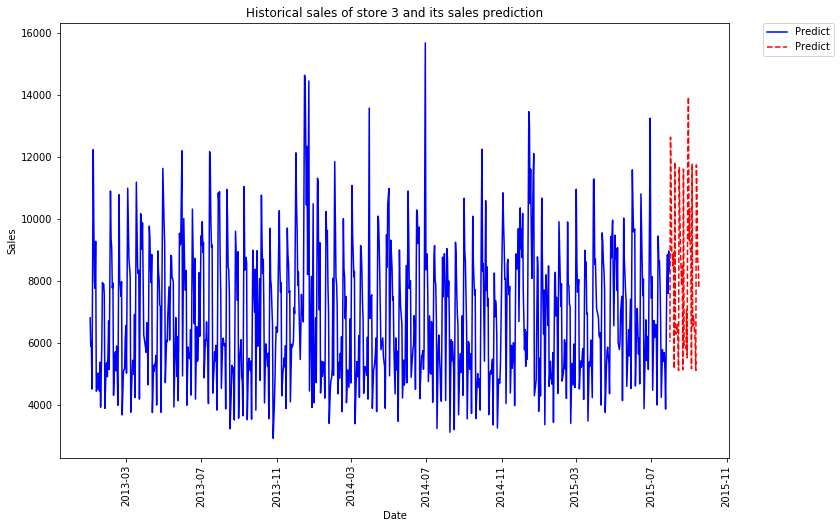

In [154]:
# The red line is the sales trend from test data, a.k.a. sales forecasting

sales_store3 = train[['Date','Sales']][(train['Store'] == 3) & (train['Open'] == '1')]
sales_store3_predict = test[['Date','Sales']][test['Store'] == 3]

plt.figure(figsize=(12, 8))
plt.plot(pd.to_datetime(sales_store3.Date), sales_store3.Sales, '-b', label='Predict')
plt.plot(pd.to_datetime(sales_store3_predict.Date), sales_store3_predict.Sales, '--r', label='Predict')

plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)
plt.title('Historical sales of store 3 and its sales prediction')
plt.show()

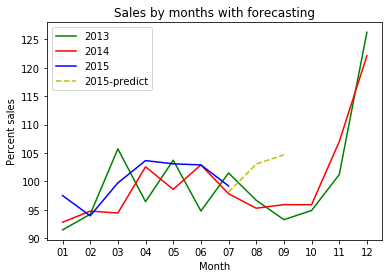

In [214]:
# The yellow line is the sales trend from test data, a.k.a. sales forecasting

saleAndDate = train[['Sales','Date']][train['Sales'] != 0]
saleByMonth2013 = saleAndDate[saleAndDate['Date'].dt.year == 2013].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2014 = saleAndDate[saleAndDate['Date'].dt.year == 2014].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015 = saleAndDate[saleAndDate['Date'].dt.year == 2015].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015_test = test.groupby(test['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015_predict = saleByMonth2015.append(saleByMonth2015_test)


plt.plot(saleByMonth2013.keys(), (saleByMonth2013 / np.mean(saleByMonth2013)) * 100, '-g', label = '2013')
plt.plot(saleByMonth2014.keys(), (saleByMonth2014 / np.mean(saleByMonth2014)) * 100, '-r', label = '2014')
plt.plot(saleByMonth2015.keys(), (saleByMonth2015 / np.mean(saleByMonth2015)) * 100, '-b', label = '2015')
plt.plot(saleByMonth2015_predict.iloc[6:9].keys(), ((saleByMonth2015_test / np.mean(saleByMonth2015_test)) * 100)[6:9],
'--y', label = '2015-predict')

plt.xlabel('Month')
plt.ylabel('Percent sales')
plt.title('Sales by months with forecasting')
plt.legend()
plt.show()